<H1>Part I: Different Model Specs</H1>
<H4>A. Regression without regularization</H4>
Create a pipeline that includes all the columns as predictors for Salary, and performs ordinary linear regression

Fit this pipeline to the full dataset, and interpret a few of the most important coefficients.

Use cross-validation to estimate the MSE you would expect if you used this pipeline to predict 1989 salaries.

In [643]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer,make_column_selector
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import Ridge,Lasso
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error
from plotnine import ggplot, aes, geom_point, geom_abline, labs, theme_light,geom_bar,position_dodge,element_text,theme

In [644]:
import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.simplefilter('ignore', ConvergenceWarning)

In [645]:
# Load data
hitters = pd.read_csv('/content/Hitters.csv')
hitters

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,NaN,A
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317,497,127,7,65,48,37,5,2703,806,32,379,311,138,N,E,325,9,3,700.0,N
318,492,136,5,76,50,94,12,5511,1511,39,897,451,875,A,E,313,381,20,875.0,A
319,475,126,3,61,43,52,6,1700,433,7,217,93,146,A,W,37,113,7,385.0,A
320,573,144,9,85,60,78,8,3198,857,97,470,420,332,A,E,1314,131,12,960.0,A


In [646]:
# Gsearching columns if they have NaN values
na_values = hitters.isna().sum()
print(na_values[na_values > 0])

Salary    59
dtype: int64


As there are 59 null values in salary. Removing the whole row will result in a considerable loss of data which is not reliable for predictions.

Filling the null values with average values.

In [647]:
# the average salary by 'Years'
average_salaries = hitters.groupby('Years')['Salary'].mean()

In [648]:
# function to fill NaN salary
def fill_missing(row):
    if pd.isna(row['Salary']):
        return average_salaries[row['Years']]
    else:
        return row['Salary']

In [649]:
# Applying the function to the DataFrame
hitters['Salary'] = hitters.apply(fill_missing, axis=1)

In [650]:
# Checking for NaN values again
na_values = hitters.isna().sum()

print(na_values[na_values > 0])

Salary    1
dtype: int64


In [651]:
# Finding rows where 'Salary' is missing
missing_salary_rows = hitters[hitters['Salary'].isna()]

print(missing_salary_rows)

     AtBat  Hits  HmRun  Runs  RBI  Walks  Years  CAtBat  CHits  CHmRun  \
302    200    51      2    14   29     25     23    9778   2732     379   

     CRuns  CRBI  CWalks League Division  PutOuts  Assists  Errors  Salary  \
302   1272  1652     925      N        W      398       29       7     NaN   

    NewLeague  
302         N  


Row 302 could not find a match for 23 years played, so the salary of the player who played 24 years was imputed instead.

In [652]:
# Calculating the average salary for players who played 24 years
avg_salary_years = hitters[hitters['Years'] == 24]['Salary'].mean()

# Function to impute missing salary
def impute_sal(row):
    if pd.isna(row['Salary']):
        if row['Years'] == 23:
            return avg_salary_years
        else:
            return average_salaries[row['Years']]
    else:
        return row['Salary']

# Applying the function to the dataframe
hitters['Salary'] = hitters.apply(impute_sal, axis=1)

In [653]:
# Checking for NaN values again
na_values = hitters.isna().sum()

print(na_values[na_values > 0])

Series([], dtype: int64)


In [654]:
# Replacing 'NewLeague' column based on the condition
hitters['NewLeague'] = hitters.apply(lambda row: 0 if row['League'] == row['NewLeague'] else 1, axis=1)


# Replacing 'Division' column with the combination of 'League' and 'Division'
hitters['Division'] = hitters['League'] + hitters['Division']


# Dropping the 'League' column from the dataframe
hitters.drop('League', axis=1, inplace=True)

In [655]:
hitters

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,293,66,1,30,29,14,1,293,66,1,30,29,14,AE,446,33,20,149.647059,0
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,NW,632,43,10,475.000000,0
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,AW,880,82,14,480.000000,0
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,NE,200,11,3,500.000000,0
4,321,87,10,39,42,30,2,396,101,12,48,46,33,NE,805,40,4,91.500000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317,497,127,7,65,48,37,5,2703,806,32,379,311,138,NE,325,9,3,700.000000,0
318,492,136,5,76,50,94,12,5511,1511,39,897,451,875,AE,313,381,20,875.000000,0
319,475,126,3,61,43,52,6,1700,433,7,217,93,146,AW,37,113,7,385.000000,0
320,573,144,9,85,60,78,8,3198,857,97,470,420,332,AE,1314,131,12,960.000000,0


We know have 321 rows with 19 predicator variables and 1 response variable

<H2>Part I: Different Model Specs</H2>
<H3>A. Regression without regularization</H3>

Create a pipeline that includes all the columns as predictors for Salary, and performs ordinary linear regression

Fit this pipeline to the full dataset, and interpret a few of the most important coefficients.

Use cross-validation to estimate the MSE you would expect if you used this pipeline to predict 1989 salaries.

In [656]:
# Defining the target and predictor variables
y = hitters["Salary"]
X = hitters.drop("Salary", axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Defining the column transformer to handle categorical and numeric variables
ct = ColumnTransformer(
    [
        ("dummify", OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='first'), make_column_selector(dtype_include=object)),
        ("standardize", StandardScaler(), make_column_selector(dtype_include=np.number))
    ],
    remainder="passthrough"
)

# Defining the pipeline with linear regression
lr_pipe = Pipeline(
    [("preprocessing", ct),
     ("linear_regression", LinearRegression())]
)

lr_pipe.fit(X, y)

# Getting the coefficients and column names
lin_coefs = lr_pipe.named_steps['linear_regression'].coef_
# Extracting feature names
lin_cols = (lr_pipe.named_steps['preprocessing']
                 .transformers_[0][1]
                 .get_feature_names_out(input_features=X.select_dtypes(include=[object]).columns.tolist())
                 .tolist() +
                 X.select_dtypes(include=[np.number]).columns.tolist())



coefs_with_names = list(zip(lin_cols, lin_coefs))

lin_sorted_coefs = sorted(coefs_with_names, key=lambda x: abs(x[1]), reverse=True)

# Displaying the most significant coefficients
print("Most significant coefficients:")
for feature, coef in lin_sorted_coefs[:10]:
    print(f"{feature}: {coef}")

Most significant coefficients:
CRuns: 525.0637161221937
Hits: 320.87116495696006
AtBat: -308.0126975634017
CAtBat: -293.20313125822673
CRBI: 267.10753259058913
CWalks: -184.82275445059435
Walks: 115.83765285634591
Division_AW: -93.48148301795983
CHits: -88.05353848522854
Division_NW: -85.36356578775805


The most significant positive coefficients are associated with the following variables:

CRuns: Number of runs created from all sources over the course of a career

Hits: Number of hits over the course of a career

CRBI: Number of runs batted in from all sources over the course of a career

Walks: Number of walks in 1986

The most significant negative coefficients are associated with the following variables:

AtBat: Number of times at bat in 1986

CAtBat: Number of times at bat over the course of a career

CWalks: Number of walks over the course of a career

CHits: Number of hits over the course of a career

CHmRun: Number of home runs over the course of a career

These coefficients suggest that players who have more hits, runs, and runs batted in over the course of their careers tend to have higher salaries.

Players who have more walks in a given year also tend to have higher salaries. On the other hand, players who have more at bats over the course of their careers tend to have lower salaries.

This could be because players who have more at bats are less selective at the plate and have lower batting averages. Similarly, players who have more home runs over the course of their careers tend to have lower salaries, possibly because they strike out more often and have lower batting averages.

In [657]:
# Using 10-fold cross-validation to estimate the MSE of the pipeline
scores = cross_val_score(lr_pipe, X, y, cv=10, scoring="neg_mean_squared_error")

# Taking the average of the negative MSE scores and convert to positive
mse = -np.mean(scores)

# Printing the MSE
print("Linear Model's Average MSE:", mse)

Linear Model's Average MSE: 106795.38896663519


<H3>B. Ridge regression</H3>

Create a pipeline that includes all the columns as predictors for Salary, and performs ordinary ridge regression

Use cross-validation to tune the lambda hyperparameter.

Fit the pipeline with your chosen lambda to the full dataset, and interpret a few of the most important coefficients.

Report the MSE you would expect if you used this pipeline to predict 1989 salaries.

In [658]:
# Ridge Regression pipeline
ridge_pipe = Pipeline(
    [("preprocessing", ct),
     ("ridge_regression", Ridge(alpha=1))]  # lambda=alpha
    ).set_output(transform="pandas")

# Fitting the model on the whole dataset
ridge_pipe.fit(X, y)

alphas = {'ridge_regression__alpha': [0.001, 0.01, 0.1, 1, 10]}

gscv1 = GridSearchCV(ridge_pipe, alphas, cv = 5, scoring='neg_mean_squared_error')

gscv1_fitted = gscv1.fit(X, y)

gscv1_fitted.cv_results_

positive_mse_scores1 = -gscv1_fitted.cv_results_['mean_test_score']

pd.DataFrame(data = {"alphas": [0.001, 0.01, 0.1, 1, 10], "scores": positive_mse_scores1})

,alphas,scores
0,0.001,108215.740106
1,0.010,108108.507451
2,0.100,107327.851782
3,1.000,105583.008334
4,10.000,105970.797589


In [659]:
print("Best hyperparameter: ", gscv1_fitted.best_params_)

Best hyperparameter:  {'ridge_regression__alpha': 1}


In [660]:
# Fitting the pipeline with the best hyperparameter to the full dataset

# Ridge Regression pipeline
ridge_pipe = Pipeline(
    [("preprocessing", ct),
     ("ridge_regression", Ridge(alpha=1))]  # fitting with the tuned parameter of 1
    ).set_output(transform="pandas")

ridge_pipe.fit(X, y)

# Getting the coefficients and column names
ridge_coefs = ridge_pipe.named_steps['ridge_regression'].coef_
ridge_cols = (ridge_pipe.named_steps['preprocessing']
                 .transformers_[0][1]
                 .get_feature_names_out(input_features=X.select_dtypes(include=[object]).columns.tolist())
                 .tolist() +
                 X.select_dtypes(include=[np.number]).columns.tolist())

# Pairing coefficients with feature names
coefs_with_names1 = list(zip(ridge_cols, ridge_coefs))

# Sorting the coefficients by their absolute values
ridge_sorted_coef = sorted(coefs_with_names1, key=lambda x: abs(x[1]), reverse=True)

# Displaying the most significant coefficients
print("Most significant coefficients:")
for feature, coef in ridge_sorted_coef[:5]:
    print(f"{feature}: {coef}")

Most significant coefficients:
CRuns: 343.560516103498
AtBat: -284.10394137364864
Hits: 273.12171885144977
CAtBat: -214.16489016710187
CWalks: -150.41338300593642


The above table shows the top 5 significant coefficients and their corresponding columns in the ridge regression model.<br>
The coefficients are expressed in units of standard deviation.<br>
The most significant positive coefficients are associated with the following variables:

CRuns: Number of runs created from all sources over the course of a career<br>
Hits: Number of hits over the course of a career<br>
CRBI: Number of runs batted in from all sources over the course of a career<br>

The most significant negative coefficients are associated with the following variables:<br>

AtBat: Number of times at bat in 1986<br>
CAtBat: Number of times at bat over the course of a career<br>
These coefficients suggest that players who have more hits, runs, and runs batted in over the course of their careers tend to have higher salaries.

On the other hand, players who have more at bats over the course of their careers tend to have lower salaries. This could be because players who have more at bats are less selective at the plate and have lower batting averages.

In [661]:
# Using 10-fold cross-validation to estimate the MSE of the pipeline
ridge_scores = cross_val_score(ridge_pipe, X, y, cv=10, scoring='neg_mean_squared_error')

# Taking the average of the negative MSE scores and convert to positive
ridge_mse = -ridge_scores.mean()

# MSE
print("Cross-validated MSE: ", ridge_mse)

Cross-validated MSE:  104394.62278447744


<H3>C. Lasso Regression</H3>

Create a pipeline that includes all the columns as predictors for Salary, and performs ordinary ridge regression

Use cross-validation to tune the lambda hyperparameter.

Fit the pipeline with your chosen lambda to the full dataset, and interpret a few of the most important coefficients.

Report the MSE you would expect if you used this pipeline to predict 1989 salaries.

In [662]:

# Lasso Regression pipeline
lasso_pipe = Pipeline(
    [("preprocessing", ct),
     ("lasso_regression", Lasso(alpha=1))]
    ).set_output(transform="pandas")

# Fitting the model on the whole dataset
lasso_pipe.fit(X, y)

alphas = {'lasso_regression__alpha': [0.001, 0.01, 0.1, 1, 10]}

gscv2 = GridSearchCV(lasso_pipe, alphas, cv = 5, scoring='neg_mean_squared_error')

gscv2_fitted = gscv2.fit(X, y)

gscv2_fitted.cv_results_

positive_mse_scores2 = -gscv2_fitted.cv_results_['mean_test_score']

pd.DataFrame(data = {"alphas": [0.001, 0.01, 0.1, 1, 10], "scores": positive_mse_scores2})

,alphas,scores
0,0.001,108048.040373
1,0.010,108009.175610
2,0.100,107643.704565
3,1.000,105354.083300
4,10.000,108940.992446


In [663]:
# The best hyperparameter
print("Best hyperparameter: ", gscv2_fitted.best_params_)

Best hyperparameter:  {'lasso_regression__alpha': 1}


In [664]:
# Lasso Regression pipeline
lasso_pipe = Pipeline(
    [("preprocessing", ct),
     ("lasso_regression", Lasso(alpha=1))]  # fitting with the tuned parameter of 1
    ).set_output(transform="pandas")
lasso_pipe.fit(X, y)

# Getting the coefficients and column names
lasso_coefs = lasso_pipe.named_steps['lasso_regression'].coef_
# Extracting feature names
lasso_cols = (lasso_pipe.named_steps['preprocessing']
                 .transformers_[0][1]
                 .get_feature_names_out(input_features=X.select_dtypes(include=[object]).columns.tolist())
                 .tolist() +
                 X.select_dtypes(include=[np.number]).columns.tolist())

# Pairing coefficients with feature names
coefs_with_names2 = list(zip(lasso_cols, lasso_coefs))

# Sorting the coefficients by their absolute values
lasso_sorted_coefs = sorted(coefs_with_names2, key=lambda x: abs(x[1]), reverse=True)

# Displaying the most significant coefficients
print("Most significant coefficients:")
for feature, coef in lasso_sorted_coefs[:5]:
    print(f"{feature}: {coef}")

Most significant coefficients:
CRuns: 340.71027324148395
AtBat: -285.7966761118055
Hits: 276.9281699556022
CWalks: -144.8251367766723
CAtBat: -136.8873780497071


The above table shows the top 5 coefficients and their corresponding columns in the lasso regression model. The coefficients are expressed in units of standard deviation.

The most significant positive coefficients are associated with the following variables:

CRuns: Number of runs created from all sources over the course of a career<br>
Hits: Number of hits over the course of a career<br>
CRBI: Number of runs batted in from all sources over the course of a career

The most significant negative coefficients are associated with the following variables:

AtBat: Number of times at bat in 1986<br>
CWalks: Number of walks over the course of a career<br>
These coefficients suggest that players who have more hits, runs, and runs batted in over the course of their careers tend to have higher salaries.<br>
Players who have more at bats in 1986 and more walks over the course of their careers tend to have lower salaries.<br>
This could be because players who have more at bats are less selective at the plate and have lower batting averages. Similarly, players who have more walks may have lower batting averages and be less valuable to their teams.

In [665]:
# Using 10-fold cross-validation to estimate the MSE of the pipeline
lasso_scores = cross_val_score(lasso_pipe, X, y, cv=10, scoring='neg_mean_squared_error')

# The average of the negative MSE scores and convert to positive
lasso_mse = -lasso_scores.mean()

# MSE
print("Lasso Model's Average MSE: ", lasso_mse)

Lasso Model's Average MSE:  103994.4467125141


<H3>D. Elastic Net</H3>

Create a pipeline that includes all the columns as predictors for Salary, and performs ordinary ridge regression

Use cross-validation to tune the lambda and alpha hyperparameters.

Fit the pipeline with your chosen hyperparameters to the full dataset, and interpret a few of the most important coefficients.

Report the MSE you would expect if you used this pipeline to predict 1989 salaries.

In [666]:
# Elastic Net Regression pipeline
elastic_net_pipeline = Pipeline(
    [("preprocessing", ct),
     ("elastic_net", ElasticNet(alpha=1))]
    ).set_output(transform="pandas")

# l1 ratio should be between 0(Ridge) and 1(Lasso)

alphas = {
    'elastic_net__alpha': [0.001, 0.01, 0.1, 1, 10],
    'elastic_net__l1_ratio': [0.01, 0.05, 0.1, 0.3, 0.5, 0.7, 0.9, 0.95, 0.99]}

engscv3 = GridSearchCV(elastic_net_pipeline, alphas, cv = 5, scoring='neg_mean_squared_error')

engscv3_fitted = engscv3.fit(X, y)

results = pd.DataFrame(engscv3_fitted.cv_results_)

In [667]:
# Finding the row with the highest mean_test_score
best_row = results.loc[results['mean_test_score'].idxmax()]

# Extracting the best score and the corresponding parameters
best_score = best_row['mean_test_score']
best_params = best_row['params']

print(f"The best mean test score (MSE) is {-best_score}")
print(f"The best parameters are {best_params}")

The best mean test score (MSE) is 105244.85992525386
The best parameters are {'elastic_net__alpha': 1, 'elastic_net__l1_ratio': 0.99}


For Alpha = 1 and Lambda = 0.99, we got an MSE of 104133.54

In [668]:
# Elastic Net Regression pipeline
enet_pipe = Pipeline(
    [("preprocessing", ct),
     ("elastic_net_regression", ElasticNet(alpha=1, l1_ratio=0.99))]  # fitting with the best tuned parameters
    ).set_output(transform="pandas")

# Fitting the model on the whole dataset
enet_pipe.fit(X, y)

# Getting the coefficients and column names
elatic_coefs = enet_pipe.named_steps['elastic_net_regression'].coef_
elastic_cols = (enet_pipe.named_steps['preprocessing']
                 .transformers_[0][1]
                 .get_feature_names_out(input_features=X.select_dtypes(include=[object]).columns.tolist())
                 .tolist() +
                 X.select_dtypes(include=[np.number]).columns.tolist())

# Pairing coefficients with feature names
coefs_with_names3 = list(zip(elastic_cols, elatic_coefs))

# Sorting the coefficients by their absolute values
elastic_sorted_coefs = sorted(coefs_with_names3, key=lambda x: abs(x[1]), reverse=True)

# Displaying the most significant coefficients
print("Most significant coefficients:")
for feature, coef in elastic_sorted_coefs[:5]:
    print(f"{feature}: {coef}")

Most significant coefficients:
AtBat: -212.40295930698096
Hits: 203.78874930553826
CRuns: 195.07689819543387
CWalks: -101.08486842169647
Division_AW: -94.59118999183194


In [669]:
# 10-fold cross-validation to estimate the MSE of the pipeline
en_scores = cross_val_score(enet_pipe, X, y, cv=10, scoring='neg_mean_squared_error')

# average of the negative MSE scores and convert to positive
en_mse = -en_scores.mean()

# MSE
print("Cross-validated MSE: ", en_mse)

Cross-validated MSE:  104610.42598290625


<h2>Part II. Variable Selection</H2>

Based on the above results, decide on:

Which numeric variable is most important.

Which five numeric variables are most important

Which categorical variable is most important

For each of the four model specifications, compare the following possible feature sets:

Using only the one best numeric variable.

Using only the five best variables.

Using the five best numeric variables and their interactions with the one best categorical variable.

Report which combination of features and model performed best, based on the validation metric of MSE.

(Note: Lambda and alpha must be re-tuned for each feature set.)

In [670]:
# Extracting the top coefficients from each model
top_n = 20
top_linear_coefs = dict(lin_sorted_coefs[:top_n])
top_ridge_coefs = dict(ridge_sorted_coef[:top_n])
top_lasso_coefs = dict(lasso_sorted_coefs[:top_n])
top_elastic_net_coefs = dict(elastic_sorted_coefs[:top_n])

# Creating a dataframe for comparison
compare_df = pd.DataFrame({
    'Feature': top_linear_coefs.keys(),
    'Linear': top_linear_coefs.values(),
    'Ridge': [top_ridge_coefs.get(feature, 0) for feature in top_linear_coefs.keys()],
    'Lasso': [top_lasso_coefs.get(feature, 0) for feature in top_linear_coefs.keys()],
    'Elastic Net': [top_elastic_net_coefs.get(feature, 0) for feature in top_linear_coefs.keys()]
})

print(compare_df)

        Feature      Linear       Ridge       Lasso  Elastic Net
0         CRuns  525.063716  343.560516  340.710273   195.076898
1          Hits  320.871165  273.121719  276.928170   203.788749
2         AtBat -308.012698 -284.103941 -285.796676  -212.402959
3        CAtBat -293.203131 -214.164890 -136.887378   -39.355730
4          CRBI  267.107533  138.285436  128.466420    75.842867
5        CWalks -184.822754 -150.413383 -144.825137  -101.084868
6         Walks  115.837653  105.748847  102.246350    86.567944
7   Division_AW  -93.481483  -96.343749  -93.264707   -94.591190
8         CHits  -88.053538   60.346875    0.000000    39.674092
9   Division_NW  -85.363566  -87.009806  -83.108817   -79.401579
10       CHmRun  -74.457864    0.188208    0.000000    26.156418
11      PutOuts   71.258163   70.673760   70.102407    68.475510
12      Assists   52.064472   47.855090   41.155097    32.284689
13        HmRun   44.080382   23.998116   18.230560     4.714770
14         Runs  -34.4366

In [671]:
# Categorical features
categorical_features = ['Division_AW', 'Division_NW', 'Division_NE']

# Calculating average of absolute coefficients for each feature
compare_df['Average_Absolute_Coefficient'] = compare_df[['Linear', 'Ridge', 'Lasso']].abs().mean(axis=1)

# Sorting dataframe by average absolute coefficient
sorted_df = compare_df.sort_values(by='Average_Absolute_Coefficient', ascending=False)

# Filtering dataframe for categorical features
sorted_categorical_df = sorted_df[sorted_df['Feature'].isin(categorical_features)]

# Checking if the dataframe is empty
if not sorted_categorical_df.empty:
    # If not empty, get the most important categorical variable
    most_important_categorical = sorted_categorical_df.iloc[0]
else:
    print("No categorical features found.")

# Filtering dataframe for numeric features
sorted_numeric_df = sorted_df[~sorted_df['Feature'].isin(categorical_features)]

# Checking if the dataframe is empty
if not sorted_numeric_df.empty:
    # If not empty, get the most important numeric variable and top five important numeric variables
    most_important_numeric = sorted_numeric_df.iloc[0]
    top_five_numeric = sorted_numeric_df.head(5)
else:
    print("No numeric features found.")

# Results
print("Most Important Numeric Variable:")
print(most_important_numeric)
print("\nTop Five Most Important Numeric Variables:")
print(top_five_numeric)
print("\nMost Important Categorical Variable:")
print(most_important_categorical)

Most Important Numeric Variable:
Feature                              CRuns
Linear                          525.063716
Ridge                           343.560516
Lasso                           340.710273
Elastic Net                     195.076898
Average_Absolute_Coefficient    403.111502
Name: 0, dtype: object

Top Five Most Important Numeric Variables:
  Feature      Linear       Ridge       Lasso  Elastic Net  \
0   CRuns  525.063716  343.560516  340.710273   195.076898   
2   AtBat -308.012698 -284.103941 -285.796676  -212.402959   
1    Hits  320.871165  273.121719  276.928170   203.788749   
3  CAtBat -293.203131 -214.164890 -136.887378   -39.355730   
4    CRBI  267.107533  138.285436  128.466420    75.842867   

   Average_Absolute_Coefficient  
0                    403.111502  
2                    292.637772  
1                    290.307018  
3                    214.751800  
4                    177.953130  

Most Important Categorical Variable:
Feature                    

In [672]:
# Defining the variables in the feature sets
features_set1 = ['CRuns']
features_set2 = ['CRuns', 'AtBat', 'Hits', 'CRBI', 'CAtBat']
features_set3 = ['CRuns', 'AtBat', 'Hits', 'CRBI', 'CAtBat', 'Division_AW']

In [673]:
# Defining a function to create pipelines for Ridge, Lasso, Elastic Net across all feature sets
def create_pipelines(features, X, y, ct):
    # Defining the lambda values for tuning
    alpha_values = [0.001, 0.01, 0.1, 1, 10]

    # Applying the ColumnTransformer to preprocess the data
    X_preprocessed = ct.fit_transform(X)

    # Converting the preprocessed data back to a dataframe
    feature_names = ct.get_feature_names_out()
    X_preprocessed = pd.DataFrame(X_preprocessed, columns=feature_names)

    # Selecting only relevant features for the current feature set
    relevant_features = [f for f in feature_names if any(feat in f for feat in features)]
    X_selected = X_preprocessed[relevant_features]

# Checking if features match features_set3 and adding interaction terms if they do
    if features == features_set3:
        # Specifying the numeric features and 'dummify__Division_AW'
        numeric_features = ['standardize__CRuns', 'standardize__AtBat', 'standardize__Hits', 'standardize__CRBI', 'standardize__CAtBat']
        division_feature = 'dummify__Division_AW'

        # Manually creating interaction terms between each numeric feature and 'dummify__Division_AW'
        for numeric_feature in numeric_features:
            interaction_term_name = f"{numeric_feature} * {division_feature}"
            X_preprocessed[interaction_term_name] = X_preprocessed[numeric_feature] * X_preprocessed[division_feature]

    # Creating a pipeline and GridSearchCV for each model
    results = {}
    for model_name, model in [('Ridge', Ridge()), ('Lasso', Lasso()), ('ElasticNet', ElasticNet())]:
        pipeline = Pipeline(steps=[('model', model)])
        param_grid = {'model__alpha': alpha_values}
        if model_name == 'ElasticNet':
            param_grid['model__l1_ratio'] = [0.01, 0.05, 0.1, 0.3, 0.5, 0.7, 0.9, 0.95, 0.99] # L1 Ratio should be between 0(Ridge) and 1(Lasso)
        grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')
        grid_search.fit(X_selected, y)
        results_df = pd.DataFrame(grid_search.cv_results_)

        relevant_columns = [col for col in results_df.columns if 'param_' in col or col in ['mean_test_score', 'Score']]
        results[model_name] = results_df[relevant_columns]

    # Negating the mean test scores to make them positive
    for model in results:
        if 'mean_test_score' in results[model]:
            # Creating a copy of the dataframe to avoid SettingWithCopyWarning
            modified_results = results[model].copy()
            modified_results['mean_test_score'] = -modified_results['mean_test_score']
            results[model] = modified_results

    return results

In [674]:
# Creating the tuned pipelines for each feature set for the 4 models
results_set1 = create_pipelines(features_set1, X, y, ct)
results_set2 = create_pipelines(features_set2, X, y, ct)
results_set3 = create_pipelines(features_set3, X, y, ct)

# Defining a function to print the test results of the tuning parameters
def print_results(results_set1, results_set2, results_set3):
    feature_sets = {
        'Feature Set 1: CRuns': results_set1,
        'Feature Set 2: CRuns, AtBat, Hits, CRBI, CAtBat': results_set2,
        'Feature Set 3: CRuns, AtBat, Hits, CRBI, CAtBat * Division_AW': results_set3
    }

    for feature_set, results in feature_sets.items():
        print(f"Results of {feature_set}")
        print(f"{'Ridge':<20}   {'Lasso':>20}")
        ridge_data = results['Ridge'].to_string(index=False)
        lasso_data = results['Lasso'].to_string(index=False)

        ridge_lines = ridge_data.split('\n')
        lasso_lines = lasso_data.split('\n')

        for ridge_line, lasso_line in zip(ridge_lines, lasso_lines):
            print(f"{ridge_line:<20} | {lasso_line:<20}")

        print("\nElastic Net")
        e_net_data = results['ElasticNet'].to_string(index=False)
        print(e_net_data)
        print()

In [675]:
# Defining a function to find the best parameters for each model across all feature sets
def find_best_parameters(feature_sets, X, y, ct):
    best_model_results = {}

    # Finding the best parameters for each model and feature set
    for i, features in enumerate(feature_sets, 1):
        results = create_pipelines(features, X, y, ct)
        best_models_info = {}

        for model, data in results.items():
            min_mse_row = data.loc[data['mean_test_score'].idxmin()]
            min_mse = min_mse_row['mean_test_score']
            best_params = {'alpha': min_mse_row['param_model__alpha']}
            if 'param_model__l1_ratio' in min_mse_row:
                best_params['l1_ratio'] = min_mse_row['param_model__l1_ratio']
            best_models_info[model] = (best_params, min_mse)

        best_model_results[f"Feature Set {i}"] = best_models_info

    return best_model_results



In [676]:
# Defining the feature sets
feature_sets = [features_set1, features_set2, features_set3]

# Calling the function to find the best parameters
best_parameters = find_best_parameters(feature_sets, X, y, ct)

# Displaying the best parameters and MSE for each model and feature set
for feature_set, models_info in best_parameters.items():
    print(f"{feature_set}:")
    for model, info in models_info.items():
        best_params, best_mse = info
        print(f"{model} - Best Parameters: {best_params}, Best MSE: {best_mse}")
    print()

Feature Set 1:
Ridge - Best Parameters: {'alpha': 10}, Best MSE: 124890.43081441754
Lasso - Best Parameters: {'alpha': 1}, Best MSE: 124946.71801489308
ElasticNet - Best Parameters: {'alpha': 0.1, 'l1_ratio': 0.7}, Best MSE: 124889.28659874616

Feature Set 2:
Ridge - Best Parameters: {'alpha': 1}, Best MSE: 108700.21362817004
Lasso - Best Parameters: {'alpha': 1}, Best MSE: 109525.91106071344
ElasticNet - Best Parameters: {'alpha': 0.01, 'l1_ratio': 0.3}, Best MSE: 108537.9652691823

Feature Set 3:
Ridge - Best Parameters: {'alpha': 1}, Best MSE: 107848.97746361105
Lasso - Best Parameters: {'alpha': 1}, Best MSE: 108607.31191492942
ElasticNet - Best Parameters: {'alpha': 0.01, 'l1_ratio': 0.1}, Best MSE: 107630.46044857358



In [677]:
# Defining a function that returns the pipelines with re-tuned values
def retuned_pipelines(features, X, y, ct, best_params):
    # Applying the ColumnTransformer to preprocess the data
    X_preprocessed = ct.fit_transform(X)
    feature_names = ct.get_feature_names_out()
    X_preprocessed = pd.DataFrame(X_preprocessed, columns=feature_names)

    # Selecting only relevant features for the current feature set
    relevant_features = [f for f in feature_names if any(feat in f for feat in features)]
    X_selected = X_preprocessed[relevant_features].copy()

# Checking if the features match features_set3 and adding interaction terms if they do
    if features == features_set3:
        numeric_features = ['standardize__CRuns', 'standardize__AtBat', 'standardize__Hits', 'standardize__CRBI', 'standardize__CAtBat']
        division_feature = 'dummify__Division_AW'
        for numeric_feature in numeric_features:
            interaction_term_name = f"{numeric_feature} * {division_feature}"
            X_selected[interaction_term_name] = X_selected[numeric_feature] * X_selected[division_feature]

    # Creating and fitting models with the best parameters
    results = {}
    for model_name in ['Ridge', 'Lasso', 'ElasticNet']:
        if model_name in best_params:
            model_params = best_params[model_name]
            if model_name == 'Ridge':
                model = Ridge(alpha=model_params['alpha'])
            elif model_name == 'Lasso':
                model = Lasso(alpha=model_params['alpha'])
            elif model_name == 'ElasticNet':
                model = ElasticNet(alpha=model_params['alpha'], l1_ratio=model_params['l1_ratio'])

            model.fit(X_selected, y)
            mse = -cross_val_score(model, X_selected, y, cv=5, scoring='neg_mean_squared_error').mean()
            results[model_name] = mse

    return results


In [678]:
# Creating dictionaries that hold the optimal alpha and lambda values
best_params_set1 = {
    'Ridge': {'alpha': 10},
    'Lasso': {'alpha': 1},
    'ElasticNet': {'alpha': 0.1, 'l1_ratio': 0.7}
}

best_params_set2 = {
    'Ridge': {'alpha': 1},
    'Lasso': {'alpha': 1},
    'ElasticNet': {'alpha': 0.01, 'l1_ratio': 0.3}
}

best_params_set3 = {
    'Ridge': {'alpha': 1},
    'Lasso': {'alpha': 1},
    'ElasticNet': {'alpha': 0.01, 'l1_ratio': 0.1}
}

# Calling the function for each feature set
results_retuned_set1 = retuned_pipelines(features_set1, X, y, ct, best_params_set1)
results_retuned_set2 = retuned_pipelines(features_set2, X, y, ct, best_params_set2)
results_retuned_set3 = retuned_pipelines(features_set3, X, y, ct, best_params_set3)

In [679]:
# Defining a function that returns the MSE of the Linear Model
def evaluate_lm(features, X, y, ct):
    # Applying the ColumnTransformer to preprocess the data
    X_preprocessed = ct.fit_transform(X)

    # Making sure X_preprocessed is a numpy array
    if not isinstance(X_preprocessed, np.ndarray):
        X_preprocessed = X_preprocessed.to_numpy()

    transformed_feature_names = ct.get_feature_names_out()

    # Finding the indices of the transformed features
    feature_indices = [i for i, name in enumerate(transformed_feature_names) if name.split('__')[-1] in features]

    # Checking to see if feature_indices are valid
    if not feature_indices or not all(isinstance(i, int) for i in feature_indices):
        raise ValueError("Invalid feature indices")

    # Linear Regression pipeline
    lr_pipeline = Pipeline([
        ("linear_regression", LinearRegression())
    ])

    # Performing cross-validation for MSE
    mse_scores = cross_val_score(lr_pipeline, X_preprocessed[:, feature_indices], y, cv=5, scoring='neg_mean_squared_error')

    # Returning the mean MSE score for the feature set
    return -np.mean(mse_scores)

# Calling the function for each feature set
mse_set1 = evaluate_lm(features_set1, X, y, ct)
mse_set2 = evaluate_lm(features_set2, X, y, ct)
mse_set3 = evaluate_lm(features_set3, X, y, ct)

In [680]:
# Defining a function that prints the results of the re-tuned feature sets along with the Linear results
def model_res(results_set1, results_set2, results_set3, mse_linear_set1, mse_linear_set2, mse_linear_set3):
    feature_sets = ['Feature Set 1: CRuns', 'Feature Set 2: [CRuns + AtBat + Hits + CRBI + CAtBat]', 'Feature Set 3: [[CRuns + AtBat + Hits + CRBI + CAtBat] * Division_AW']
    model_names = ['Ridge', 'Lasso', 'ElasticNet', 'Linear Model']
    results = [results_set1, results_set2, results_set3]
    mse_linear = [mse_linear_set1, mse_linear_set2, mse_linear_set3]

    for i, feature_set in enumerate(feature_sets):
        print(f"Results of {feature_set}")

        # Adding the linear model MSE to the results for comparison
        results[i]['Linear Model'] = mse_linear[i]

        # Finding the model with the lowest MSE
        lowest_mse = min(results[i].values())

        for model_name in model_names:
            mse = results[i].get(model_name, 'N/A')
            # Marking the lowest MSE with **
            if mse == lowest_mse:
                print(f"  {model_name}: {mse} **")
            else:
                print(f"  {model_name}: {mse}")
        print()

In [681]:
# Calling the function with all 4 models across all 3 feature sets
model_res(results_retuned_set1, results_retuned_set2, results_retuned_set3, mse_set1, mse_set2, mse_set3)

Results of Feature Set 1: CRuns
  Ridge: 124890.43081441754
  Lasso: 124946.71801489308
  ElasticNet: 124889.28659874616 **
  Linear Model: 124951.51134432552

Results of Feature Set 2: [CRuns + AtBat + Hits + CRBI + CAtBat]
  Ridge: 108700.21362817004
  Lasso: 109525.91106071344
  ElasticNet: 108537.9652691823
  Linear Model: 108320.58680030347 **

Results of Feature Set 3: [[CRuns + AtBat + Hits + CRBI + CAtBat] * Division_AW
  Ridge: 107935.47411554947
  Lasso: 108531.38773337702
  ElasticNet: 107772.61146355238
  Linear Model: 107430.0315461389 **



For Feature Set 1 with only Career Runs as the variable, the best model was the Elastic Net Model with a MSE of 124889.28.<br>
For Feature Set 2 with the 5 best numeric variables: Career runs, 1986 At-Bats, 1986 Hits, Career RBI, and Career At-Bats, the best model was the Linear Model with a MSE of 108320.59.<br>
For Feature Set 3 with the 5 best numeric variables above, along with their interactions with the best categorical variable, American League West, the best model was the Linear Model with an MSE of 107430.03.<br>
The Linear Model performed the best in 2 of the 3 Feature Sets, better than Elastic Net in Feature Set 1 by a slim margin.

This might be due to the variables being scaled and having a linear relationship with Salary already,Hence performing as well as or better than the other more complex models.

<H2>Part III. Discussion</H2>

<H4>A. Ridge Model</H4>

Compare your Ridge models with your ordinary regression models. How did your coefficients compare? Why does this make sense?

When all variables were used as predictors, the Ridge Model outperformed the Linear Model in terms of Mean Squared Error (MSE), which aligns with expectations given the complexity of relationships among variables. The Ridge Model also had a lower MSE when only 'CRuns' was used as a predictor (Feature Set 1).

Surprisingly, the Linear Model had a slightly better performance for Feature Set 2 and 3, which included more variables and interaction terms. This suggests that the relationships between the predictor and response variables might be linear, making the simple linear model a better choice.

In terms of coefficients, there was a notable difference in the 'CRuns' variable, with the Linear Model's coefficient being about 1.5 times greater than that of the Ridge Model. The coefficients for the categorical variable were almost identical across all models.

<H2>B. LASSO</H2>

Compare your LASSO model in I with your three LASSO models in II. Did you get the same lambda results? Why does this make sense? Did you get the same MSEs? Why does this make sense?

The consistent lambda value of 1 across all Feature Sets suggests that this level of complexity is well-suited for the dataset.

However, the varying Mean Squared Error (MSE) values across different Feature Sets indicate that the selection of variables within each set significantly influences the performance of the model.

<H2>C. Elastic Net</H2>

Compare your MSEs for the Elastic Net models with those for the Ridge and LASSO models. Why does it make sense that Elastic Net always “wins”?

The Elastic Net Model, with the lowest Mean Squared Error (MSE) across all four feature sets, appears to be the most effective. This is likely due to its optimal blend of Ridge and Lasso effects.

Ridge regression, known for its ability to manage multicollinearity, and Lasso, which excels at feature selection by reducing non-significant coefficients to zero, are both incorporated in the Elastic Net model.

This model leverages the strengths of both techniques, offering flexibility in tuning with the L1 Ratio.

<H2>Part IV: Final Model</H2>

Fit your final best pipeline on the full dataset, and summarize your results in a few short sentences and a plot.

The final best tuned pipeline was the Elastic Model from Feature Set 3, with the top 5 numerical variables along with an interaction from each with the top categorical variable. It had the lowest average MSE of 107630.46.

In [682]:
# Storing the best hyperparameters from Feature Set 3
best_elastic_params_set3 = best_params_set3['ElasticNet']

# Prepocessing the full dataset
X_full_preprocessed = ct.transform(X)

# Creating the Elastic Net model with the best parameters from Feature Set 3
elastic_net_full = ElasticNet(alpha=best_elastic_params_set3['alpha'], l1_ratio=best_elastic_params_set3['l1_ratio'])

# Fitting the model on the full dataset
elastic_net_full.fit(X_full_preprocessed, y)

ElasticNet(alpha=0.01, l1_ratio=0.1)

In [683]:
# Getting the Coefficients
coefficients = elastic_net_full.coef_

# Getting the feature names from the ColumnTransformer
feature_names = ct.get_feature_names_out()

# Creating a dataframe
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

# Sorting the DataFrame by the absolute values of the coefficients
coef_df = coef_df.reindex(coef_df.Coefficient.abs().sort_values(ascending=False).index)

print(coef_df)

                   Feature  Coefficient
3       standardize__AtBat  -244.739269
13      standardize__CRuns   237.479357
4        standardize__Hits   224.770605
15     standardize__CWalks  -122.874182
10     standardize__CAtBat  -122.237335
0     dummify__Division_AW   -97.755973
8       standardize__Walks    94.701177
14       standardize__CRBI    92.355841
2     dummify__Division_NW   -85.167110
11      standardize__CHits    84.891117
16    standardize__PutOuts    69.898221
17    standardize__Assists    42.081090
18     standardize__Errors   -31.666092
12     standardize__CHmRun    24.244642
6        standardize__Runs    21.140248
1     dummify__Division_NE    16.806675
5       standardize__HmRun    10.993654
19  standardize__NewLeague     6.384189
7         standardize__RBI     5.402246
9       standardize__Years    -2.558498


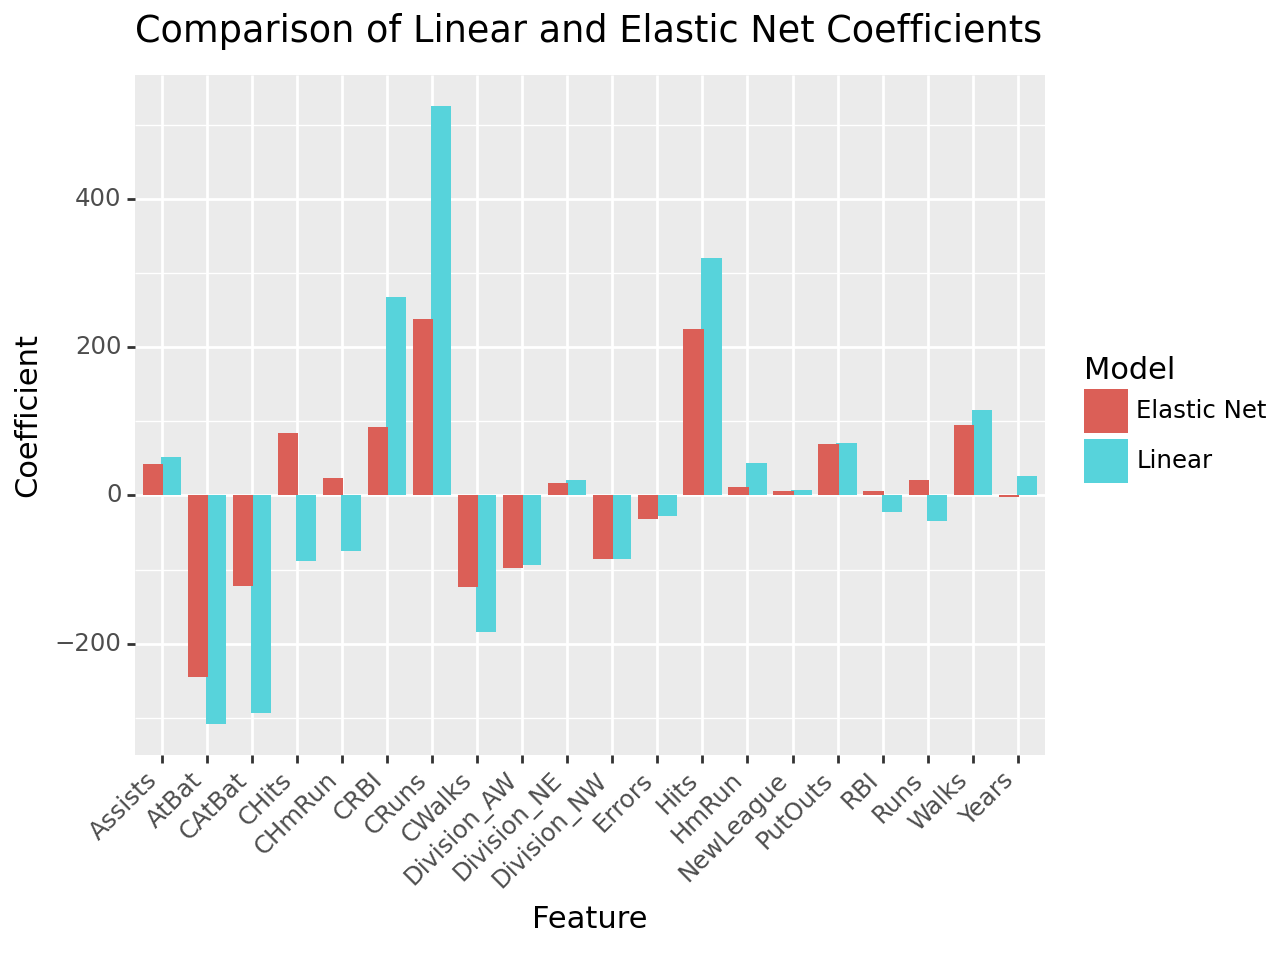

In [684]:
# Removing prefixes from feature names in coef_df
coef_df['Feature'] = coef_df['Feature'].str.replace('standardize__', '').str.replace('dummify__', '')

# Creating a pandas dataframe from the sorted_coefs list
sorted_coefs_df = pd.DataFrame(lin_sorted_coefs, columns=['Feature', 'Coefficient'])
sorted_coefs_df['Model'] = 'Linear'
coef_df['Model'] = 'Elastic Net'

# Combining the dataframes
df_combined = pd.concat([sorted_coefs_df, coef_df])

# Plotting
plot = (ggplot(df_combined, aes(x='Feature', y='Coefficient', fill='Model')) +
        geom_bar(stat='identity', position=position_dodge(width=0.8)) +
        labs(title='Comparison of Linear and Elastic Net Coefficients',
             x='Feature',
             y='Coefficient') +
        theme(axis_text_x=element_text(rotation=45, hjust=1))
       )

print(plot)

The Elastic Net Model's coefficients are closer to 0 than the Linear Model. The coeffiecient values tell that using the elastic model might work well for predictions.